## Problem Satement

SafeBabies is a large company who is producing car seats for babies and toddlers. They sell their products all over the US and abroad. The management team has hired you as a Business Analytics consultant to help them maximizing their profit.

The primary tasks are to determine:
1. The optimal price for selling the car seats at those stores where the shelve location is good (i.e. the product is highly visible)?
2. The optimal price for selling the car seats at those stores where the shelve location is bad (i.e. the product is highly visible)?
3. Plot the optimal price for selling the car seats at those stores where the shelve location is good and those where the shelve location is bad when varying the production costs from \\$40 to \\$85.

You have been told that the __cost of producing__ each car seat is \$55.0.

In [33]:
library(ISLR)
library(magrittr)
library(dplyr)
library(ggplot2)

# Change size of graphs globally
options(repr.plot.width = 6, repr.plot.height = 5)

Our dataset named `safebabies_df` will consist of 3 variables for the 400 stores of SafeBabies.

In [3]:
safebabies_df <- Carseats %>% select(Sales, Price, ShelveLoc)
head(safebabies_df)

Sales,Price,ShelveLoc
9.50,120,Bad
11.22,83,Good
10.06,80,Medium
7.40,97,Medium
4.15,128,Bad
10.81,72,Bad


Using the `summary` function we will produce the 5 number summary of our 3 variables.

In [4]:
summary(safebabies_df)

     Sales            Price        ShelveLoc  
 Min.   : 0.000   Min.   : 24.0   Bad   : 96  
 1st Qu.: 5.390   1st Qu.:100.0   Good  : 85  
 Median : 7.490   Median :117.0   Medium:219  
 Mean   : 7.496   Mean   :115.8               
 3rd Qu.: 9.320   3rd Qu.:131.0               
 Max.   :16.270   Max.   :191.0               

where
* __Sales__ is unit sales (in thousands) at each store location
* __Price__ is the price that company charges for car seats at each site
* __ShelveLoc__ is a factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each store.

The first step to accomplishing tasks 1 and 2 is to split the dataset `safebabies_df` into two seperate datasets. The first one will contain rows (stores) where `ShelveLoc` is __Good__ and we will name it `good_df` while the second one will contain rows (stores) where `ShelveLoc` is __Bad__ and we will name it `bad_df`.

In [5]:
good_df <- safebabies_df %>% filter(ShelveLoc == "Good")
bad_df <- safebabies_df %>% filter(ShelveLoc == "Bad")

## Finding The Optimal Price

### The Intuition

Optimal price can be defined as the price that offers the best profit and is greater than the cost of production. Given the definition of optimal price, our goal is to find a price such that the total profit is maximized accross all stores.

Total profit can be defined using the following equation:

$P_t = P_u * S_u$

where

* $P_t$ is the total profit at each store
* $P_u$ is the profit per unit
* $S_u$ is the `Sales` variable (unit sales in thousands)

The goal at this stage is to express total profit per store in terms of price and to do that we must also express $P_u$ and $S_u$ in terms of price. 

$P_u$ can be expressed using the following equation:

$P_u = Price - Cost$

The equation above essentially says that the profit per unit is simple expressed as the price per unit minus the cost of producing the unit.

$S_u$ was defined as the unit sales in thousands meaning the number of units each store sold. If we were to express $S_u$ in terms of price then we would have to take inspiration from OLS, by doing that we can express $S_u$ using the following equation:

$S_u = \theta_0 + \theta_1Price$

where 
* $\theta_0$ is the y intercept
* $\theta_1$ is the coefficient for price

By using a linear regression equation (OLS) to define $S_u$ we have succeded in expressing $S_u$ (`Sales`) in terms of price. The linear regression model can easily determine the best $\theta_0$ and $\theta_1$ for predicting $S_u$

We can now redefine $P_t$ as: 

$P_t = (Price - Cost)(\theta_0 + \theta_1Price)$

and then further expand it to: 

$P_t = \theta_1Price^2 + (\theta_0 + \theta_1Cost)Price - \theta_0Cost$

The equation for $P_t$ gives of a quadratic equation which represents the price elasticity for profit which means that it will tell us how profit accross all stores changes as we change the price.

Let's define a function called `total_profit` that we compute the $P_u$

In [51]:
total_profit <- function(prod_cost, price, theta_0, theta_1) {
    return((price - prod_cost) * (theta_1 * price + theta_0))
}

### Optimal Price for Good Shelf Locations

The first thing to do is to construct our linear regression model to obtain the coefficients $\theta_0$ and $\theta_1$ which we will need when calculating total profit, $P_t$

In [52]:
good_coeffs <- lm(Sales ~ Price, data = good_df) %>% use_series("coefficients")
good_coeffs

(Intercept)       Price 
17.96886360 -0.06578477

We will then create a column call `Profit_t` which is the total profit for each store where the `ShelveLoc` is __Good__.

In [53]:
gtheta_0 <- good_coeffs[[1]]
gtheta_1 <- good_coeffs[[2]]
good_df <- good_df %>% mutate(Profit_t = total_profit(55, Price, gtheta_0, gtheta_1))

head(good_df)

Sales,Price,ShelveLoc,Profit_t
11.22,83,Good,350.2444
11.85,120,Good,654.8549
11.96,94,Good,459.6187
10.96,86,Good,381.6526
11.17,118,Good,642.9944
7.58,110,Good,590.2896


Let's find the optimal price that offers the best total profit for `ShelveLoc` categorized as __Good__. We do this by taking the store with the maximum total profit as well as the store with the maximum sales.

In [54]:
good_optimal <- good_df %>% 
    filter(Profit_t == max(Profit_t) & Price > 55) %>%
    filter(Sales > 0 & Sales == max(Sales))

good_optimal

Sales,Price,ShelveLoc,Profit_t
3.58,164,Good,782.6376


So for `ShelveLoc` categorized as __Good__ the optimal price is __$164__, okay now let's plot our dataset, `good_df`, and see how `Profit_t` changes when `Price` changes. We will also highlight where on the plot is the price and profit are optimal.

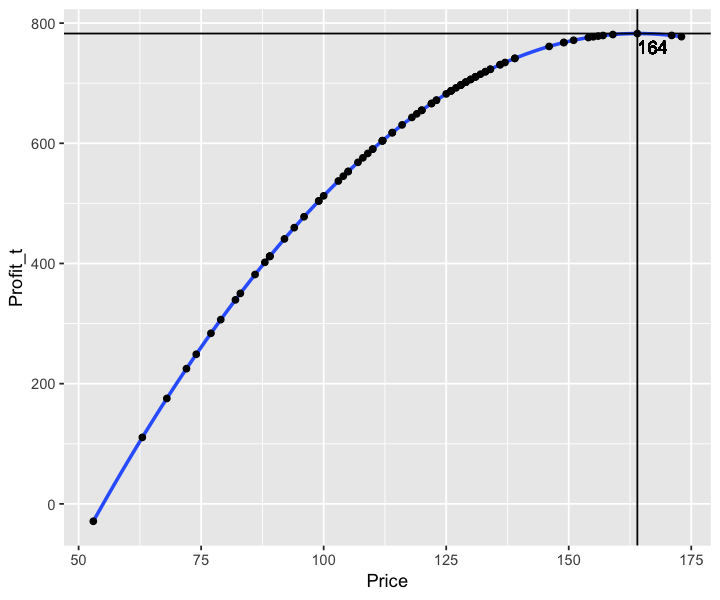

In [55]:
ggplot(good_df, aes(x = Price, y = Profit_t)) +
    geom_smooth(method = "loess") +
    geom_point() +
    geom_hline(yintercept = good_optimal$Profit_t) +
    geom_vline(xintercept = good_optimal$Price) +
    geom_text(
        aes(x = good_optimal$Price, y = good_optimal$Profit_t), 
        label = good_optimal$Price, 
        hjust = 0,
        vjust = 1.5
    )

### Optimal Price for Bad Shelf Locations

Just like in the case of good shelf locations we construct our linear regression model to obtain the coefficients $\theta_0$ and $\theta_1$ which we will need when calculating total profit, $P_t$

In [56]:
bad_coeffs <- lm(Sales ~ Price, data = bad_df) %>% use_series("coefficients")
bad_coeffs

(Intercept)       Price 
11.83298389 -0.05522028

We will then create a column call `Profit_t` which is the total profit for each store where the `ShelveLoc` is __Bad__.

In [57]:
btheta_0 <- bad_coeffs[[1]]
btheta_1 <- bad_coeffs[[2]]
bad_df <- bad_df %>% mutate(Profit_t = total_profit(55, Price, btheta_0, btheta_1))

head(bad_df)

Sales,Price,ShelveLoc,Profit_t
9.50,120,Bad,338.4258
4.15,128,Bad,347.8295
10.81,72,Bad,133.5711
9.01,100,Bad,283.9930
10.14,113,Bad,324.3994
2.99,97,Bad,272.0179


Let's find the optimal price that offers the best total profit for `ShelveLoc` categorized as __Bad__. We do this by taking the store with the maximum total profit as well as the store with the maximum sales.

In [58]:
bad_optimal <- bad_df %>% 
    filter(Profit_t == max(Profit_t) & Price > 55) %>%
    filter(Sales > 0 & Sales == max(Sales))

bad_optimal

Sales,Price,ShelveLoc,Profit_t
6.8,135,Bad,350.2597


So for `ShelveLoc` categorized as __Bad__ the optimal price is __$135__, okay now let's plot our dataset, `bad_df`, and see how `Profit_t` changes when `Price` changes. We will also highlight where on the plot is the price and profit are optimal.

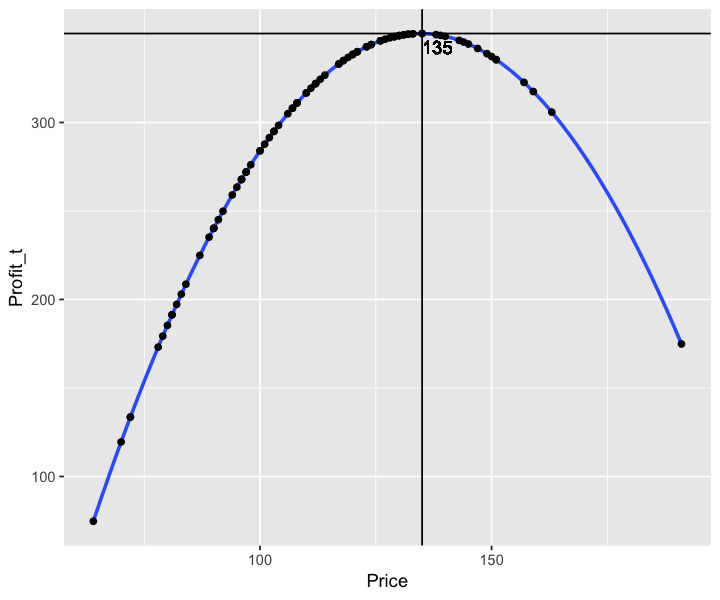

In [59]:
ggplot(bad_df, aes(x = Price, y = Profit_t)) +
    geom_smooth(method = "loess") +
    geom_point() +
    geom_hline(yintercept = bad_optimal$Profit_t) +
    geom_vline(xintercept = bad_optimal$Price) + 
    geom_text(
        aes(x = bad_optimal$Price, y = bad_optimal$Profit_t), 
        label = bad_optimal$Price, 
        hjust = 0,
        vjust = 1.5
    )

## Optimal Price as Production Cost Changes

In [62]:
prod_costs <- seq(40, 85, by = 5)

### Good Shelf Locations

   Production_Costs Optimal_Prices
1                40            157
2                45            159
3                50            164
4                55            164
5                60            164
6                65            171
7                70            171
8                75            173
9                80            173
10               85            173


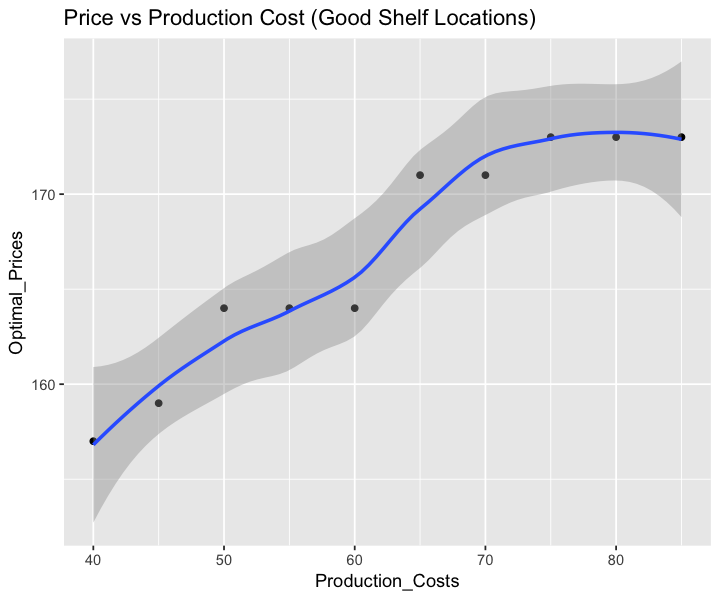

In [64]:
good_optimal_prices <- c()

local({
    # Good shelf locations
    for (prod_cost in prod_costs) {
        good_df <- good_df %>% mutate(Profit_t = total_profit(prod_cost, Price, gtheta_0, gtheta_1))

        good_optimal <- good_df %>% 
            filter(Profit_t == max(Profit_t) & Price > prod_cost) %>%
            filter(Sales > 0 & Sales == max(Sales))


        good_optimal_prices <- c(good_optimal_prices, good_optimal$Price)
    }

    good_optimal_df <- data.frame(Production_Costs = prod_costs, Optimal_Prices = good_optimal_prices)

    print(good_optimal_df)

    ggplot(good_optimal_df, aes(x = Production_Costs, y = Optimal_Prices)) +
        geom_point() +
        ggtitle("Price vs Production Cost (Good Shelf Locations)") +
        geom_smooth(method = "loess")
})

The plot titled _Price vs Production Cost (Good Shelf Locations)_ shows that as the production cost increases there comes to a point where the price doesn't change and reaches a plateau, that point is when production cost is $75 or more. Since the shelf locations of these carseats are good and they yeild high profit, cost of produ

### Bad Shelf Locations

   Production_Costs Optimal_Prices
1                40            127
2                45            130
3                50            132
4                55            135
5                60            138
6                65            140
7                70            143
8                75            145
9                80            147
10               85            150


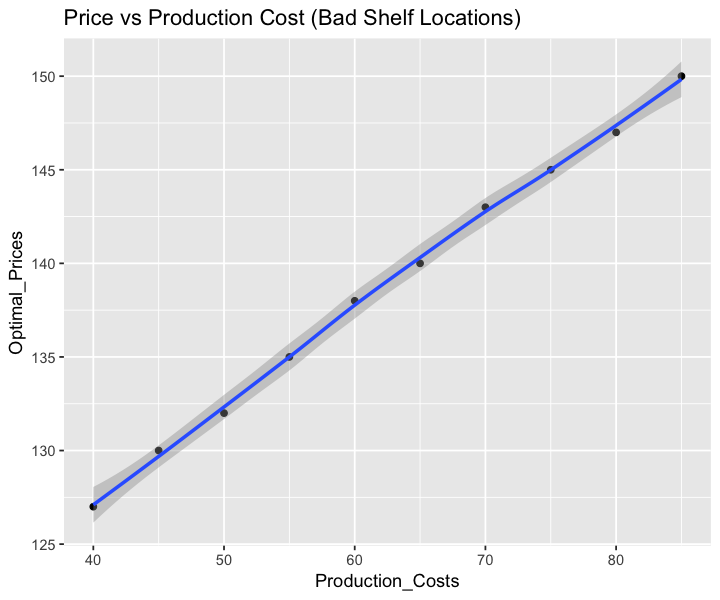

In [65]:
bad_optimal_prices <- c()

local({
    # Bad shelf locations
    for (prod_cost in prod_costs) {
        bad_df <- bad_df %>% mutate(Profit_t = total_profit(prod_cost, Price, btheta_0, btheta_1))

        bad_optimal <- bad_df %>% 
            filter(Profit_t == max(Profit_t) & Price > prod_cost) %>%
            filter(Sales > 0 & Sales == max(Sales))

        bad_optimal_prices <- c(bad_optimal_prices, bad_optimal$Price)
    }

    bad_optimal_df <- data.frame(Production_Costs = prod_costs, Optimal_Prices = bad_optimal_prices)

    print(bad_optimal_df)

    ggplot(bad_optimal_df, aes(x = Production_Costs, y = Optimal_Prices)) +
        geom_point() +
        ggtitle("Price vs Production Cost (Bad Shelf Locations)") +
        geom_smooth(method = "loess")  
})

On the other hand, the plot titled _Price vs Production Cost (Bad Shelf Locations)_ shows that as the production cost increases so does the price. Since the carseats are in a bad location production cost for each one highly affect the selling price because of the bad location they are stored in the stores.